<a href="https://colab.research.google.com/github/colinjhorgan/MLTSA22_CHorgan/blob/main/HW9/HW9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import pylab as pl
%pylab inline

from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split as tts
from sklearn.metrics import confusion_matrix

import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd /content/gdrive/MyDrive/3. MSDS Courses/Machine Learning Time Series

/content/gdrive/MyDrive/3. MSDS Courses/Machine Learning Time Series


# Read in data from HW8

Let each of the 6 passbands in the plasticc data be denoted by a,b,...,f and each unique object be associated with an integer 1,2,...,N where N is the total number of unique objects in the data.

The output of HW8 was saved as |1a|1b|1c|...|1f||2a|...|2f|...|Nf|. Therefore we must reshape the data into a 6xN matrix where the ith row corresponds to the ith passband. That is, we must coerce our data into the following form:

|1a|2a|3a|.......|Na|
|1b|2b|..........|Nb|
.... |1f|2f|....|Nf|

In [4]:
#Re-read data from HW8
data = np.load('PLAsTiCC_autoencoder_data.npy')

In [5]:
#Reshape data so each row contains all the data from each object for all 6 pass-
#bands
data_mat = np.reshape(data, (-1,600))
n_dim = data_mat.shape[1]

In [6]:
data_mat.shape

(7848, 600)

# Creating and Training an Autoencoder


In [7]:
#Define sequental model
model_encoder = Sequential()

#Compress input data
model_encoder.add(Dense(100, activation='relu', input_dim=n_dim))

#Additional Compression
model_encoder.add(Dense(50, activation='relu'))

#Decompress
model_encoder.add(Dense(100, activation='relu'))

#Return predictions of input data
model_encoder.add(Dense(n_dim, activation='linear'))

In [8]:
#Define optimizer
opt = keras.optimizers.Adam(learning_rate=1e-4)
model_encoder.compile(optimizer=opt, 
                    loss="mean_squared_error")

In [9]:
#Train model for 500 iterations, 80/20 Train Test Split
model_hist = model_encoder.fit(data_mat, data_mat, validation_split=.2, 
                               epochs=500, batch_size=100, verbose=1)

Epoch 1/500
63/63 [==============================] - 2s 10ms/step - loss: 6941448.5000 - val_loss: 87816160.0000
Epoch 2/500
63/63 [==============================] - 1s 9ms/step - loss: 6558416.5000 - val_loss: 87001184.0000
Epoch 3/500
63/63 [==============================] - 1s 9ms/step - loss: 6292785.0000 - val_loss: 86357184.0000
Epoch 4/500
63/63 [==============================] - 0s 6ms/step - loss: 6073584.0000 - val_loss: 86043896.0000
Epoch 5/500
63/63 [==============================] - 0s 7ms/step - loss: 5836567.0000 - val_loss: 85812344.0000
Epoch 6/500
63/63 [==============================] - 0s 7ms/step - loss: 5490457.5000 - val_loss: 85588176.0000
Epoch 7/500
63/63 [==============================] - 0s 5ms/step - loss: 5011254.5000 - val_loss: 85218368.0000
Epoch 8/500
63/63 [==============================] - 0s 7ms/step - loss: 4426341.5000 - val_loss: 85453640.0000
Epoch 9/500
63/63 [==============================] - 1s 8ms/step - loss: 3796039.0000 - val_loss: 84826

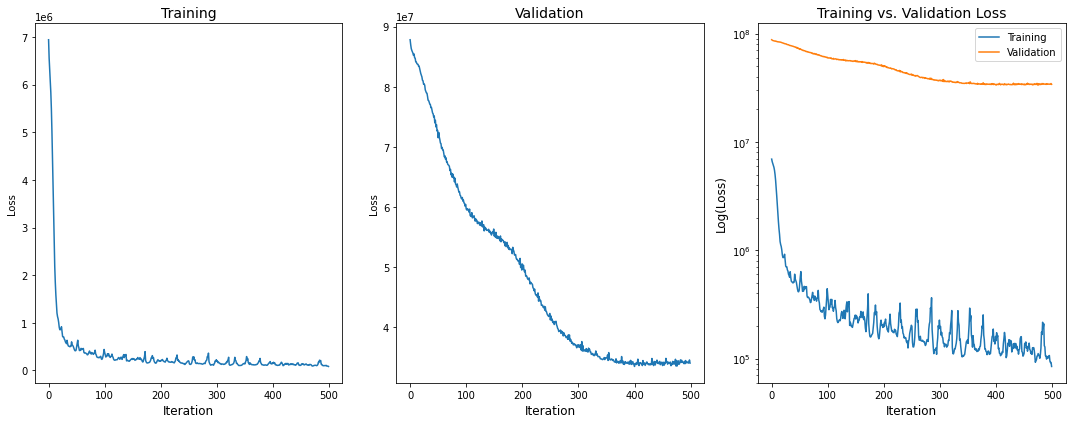

In [10]:
#Plot Loss Function for Training and Validation
fig, (ax1, ax2, ax3) = pl.subplots(1, 3, sharex=True, figsize=(15,6))

ax1.plot(model_hist.history['loss'])
ax1.set_title('Training', fontsize=14)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Iteration', fontsize=12)

ax2.plot(model_hist.history['val_loss'])
ax2.set_title('Validation', fontsize=14)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Iteration', fontsize=12)

ax3.plot(model_hist.history['loss'], label='Training')
ax3.plot(model_hist.history['val_loss'], label='Validation')
ax3.set_title('Training vs. Validation Loss', fontsize=14)
ax3.set_ylabel('Log(Loss)', fontsize=12)
ax3.set_xlabel('Iteration', fontsize=12)
ax3.legend()
ax3.set_yscale('log');

fig.tight_layout();

**Figure 1:** Training and Validation loss of our auto-encoder across 500 iterations (epochs). Note the difference in scale between Training and Validation Loss. Loss is measured using mean-squared error. Training and Validation are shown on the same scale (log10) on the right-most plot.

In the above figure we see that loss in the Training data begins to converge after only about 100 iterations, whereas loss in the Validation data begins to converge only after around 400 epochs. This confirms that, although we don't see significant increases in loss in the training set, our model still continues to learn useful information in reconstructing our input. Based on this trend, we are confident that our model is not overfitting our data. It should be noted however that loss in the validation set is an order of magnitude above the training set - so our model is not performing spectacularly.

# Comparison of Autoencoder Predictions vs. Raw Data

Here we ask the Autoencoder to recreate our input and visualize how well it is able to reconstruct the raw data from its compressed representation.

In [11]:
#Return predictions of model input from our compressed representation
preds = model_encoder.predict(data_mat)

In [12]:
def plot_bands(raw, preds, obj_id):

  '''
  Consumes raw data and predicted data and plots each of the six passbands of the
  object in the 'obj_id'th row.
  '''

  #Get object data from raw and preds
  raw_bands = raw[obj_id].reshape((6,-1))
  pred_bands = preds[obj_id].reshape((6,-1))

  #Plot raw vs. preds
  fig, axs = pl.subplots(3, 2, figsize=(15,8))
  axs = axs.flatten()

  for i in range(0,6):
    axs[i].plot(raw_bands[i], label='Raw Data')
    axs[i].plot(pred_bands[i], label='Prediction')
    axs[i].set_title(f'Passband {i}', fontsize=12)
    axs[i].set_ylabel('Flux', fontsize=10)
    axs[i].set_xlabel('Sample', fontsize=10)
    if i == 0:
      axs[i].legend(loc='upper left')

  fig.suptitle(f'Raw vs. Predicted Data: Object {obj_id}', y=1.02, 
               fontsize=14)
  fig.tight_layout();

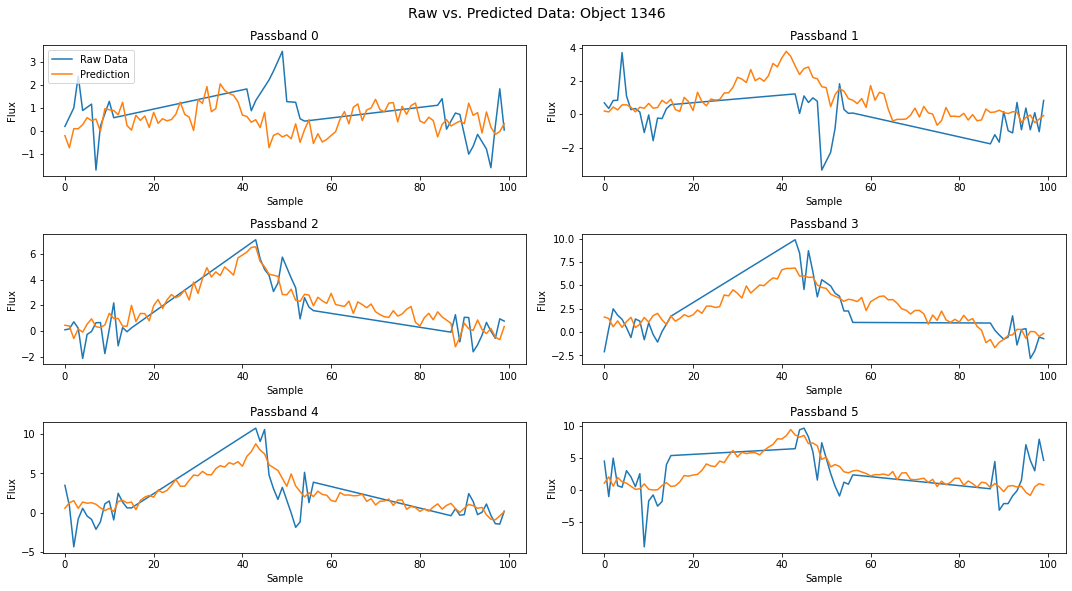

In [13]:
#Plot best-fit and worst-fit objects using MSE
MSE = ((data_mat - preds)**2).sum(axis=1)
best = np.argmin(MSE) #Object index with lowest MSE
worst = np.argmax(MSE) #Object index with largest MSE

#Best-fit
plot_bands(data_mat, preds, best)

**Figure 3:** Raw data vs. Model predictions for the best-fit object using mean-squared error. The model is definitely able to capture some of the larger trends across all 5 passbands, particularly bands 2, 3, 4, and 5. Bands 0 and 1 have comparatively poor fit.

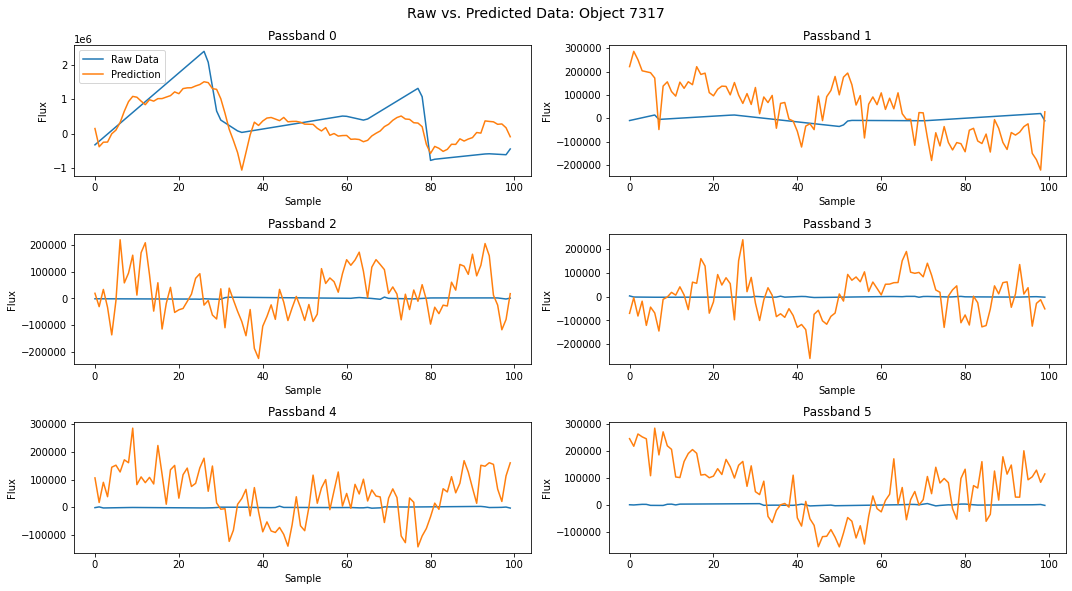

In [14]:
#Worst-fit
plot_bands(data_mat, preds, worst)

**Figure 4:** Raw data vs. Model predictions for the worst-fit object using mean-squared error. We can see that in bands 1-5 there are very poor predictions generated from the model. This is likely because these passbands have very few real observations in the plastic data - meaning that there is almost no signal in them which forces the model to make random guesses for each sample. Note that in Passband 0, where there is likely more observed data, our model makes more accurate predictions.

Together, Figures 3 and 4 suggest that when our model is given a sufficient amount of meaningful inputs - it can do a fairly decent job of compressing them and decompressing them while not losing too much signal. However, in cases where almost no signal is passed to the model it will flail around making random predictions.

It should be stated that the scale of Flux between our best fit and worst fit are significantly different from one another. This means (generally) that objects with lower flux contribute less to MSE than objects with larger flux. The difference in scale between objects may be impeding the models ability to learn and therefore it may benefit from normalized inputs. For now we will ignore this.

# Obtaining Compressed Input Representation From Intermediate Layer

Here we obtain output from the 2nd layer of the model, resulting in an array of length 50 for each object representing the input.

In [15]:
#Define new model which takes the same input as the autoencoder and returns output from the 2nd layer
compressed_model = Model(inputs=model_encoder.input, 
                         outputs=model_encoder.layers[1].output)

#Get compressed output
compressed_output = compressed_model.predict(data_mat)
compressed_output.shape

(7848, 50)

# Object Classification Using Extracted Features From HW8

Here we use the features extracted from HW8 to classify objects using a RandomForestClassifier. We will then compare the performance of this model to a model that uses only our compressed output, and a model that 

In [16]:
#Read in features from PLAsTiCC data, join compressed output
features = pd.read_csv('PLAsTiCC_features')
features = features.fillna(0)
features.head()

,object_id,raw_mean0,raw_mean1,raw_mean2,raw_mean3,raw_mean4,raw_mean5,raw_std0,raw_std1,raw_std2,...,raw_skew5,stand_median0,stand_median1,stand_median2,stand_median3,stand_median4,stand_median5,decl,ra,target
0,615,-3.254554,-385.699911,-134.146566,-121.103501,-55.954592,-47.449847,83.944735,601.787302,455.121346,...,0.125268,-10.015225,-488.057969,-265.686005,-162.170944,-103.541366,-85.524307,-61.943836,349.046051,92
1,713,-2.720398,-1.019804,-0.794238,-0.986966,-0.900262,-1.794175,7.113509,5.712334,5.770738,...,0.218182,-3.096805,-0.561736,-0.117976,-0.073897,-0.792176,-2.463012,-27.784405,53.085938,88
2,730,-0.048080,0.141057,2.400870,3.236164,4.308728,4.539396,1.828872,1.807229,5.559483,...,1.680352,0.024093,0.171336,0.491791,0.660403,1.004354,2.542647,-6.579593,33.574219,42
3,745,1.797523,5.717394,9.711532,14.412924,13.134436,10.746138,4.374445,25.964659,31.957997,...,3.170857,1.056714,0.888115,0.424360,1.361369,1.270150,2.749555,-45.586655,0.189873,90
4,1124,0.660948,4.634637,10.243968,11.086555,9.906102,6.896742,2.360084,8.107525,21.319854,...,3.657305,0.581027,1.154596,0.889142,1.014106,1.745012,1.973272,-63.823658,352.711273,90


In [17]:
#Train Random Forest on Features
X = features.drop(columns=['object_id','target'])
y = features.target

rfc = RandomForestClassifier(max_depth = 10, random_state=1)
#feature_scores = cross_val_score(rfc, X, y, cv=10, scoring='f1_weighted')
X_train, X_test, y_train, y_test = tts(X, y, test_size=.2, stratify=y)
rfc.fit(X_train, y_train)
feat_score = rfc.score(X_test, y_test)

feat_conf = pd.DataFrame(confusion_matrix(y_test, rfc.predict(X_test)), 
                  columns=y.unique(), 
                  index=y.unique())

# Object Classification Using Autoencoder Output

Here we attempt to predict object class using only the compressed output from our autoencoder

In [18]:
#Convert compressed data to dataframe for random forest
col_names = [f'f_{i}' for i in range(0,50)]
comp_df = pd.DataFrame(compressed_output, columns=col_names)

X = comp_df
y = features.target

X_train, X_test, y_train, y_test = tts(X, y, test_size=.2, stratify=y)

rfc.fit(X_train, y_train)
comp_score = rfc.score(X_test, y_test)

comp_conf = pd.DataFrame(confusion_matrix(y_test, rfc.predict(X_test)), 
                  columns=y.unique(), 
                  index=y.unique())

# Object Classification Using Joint Feature Space

Here we attempt to predict object class using both the features from HW7 and the autoencoder output.

In [19]:
#Merge features and compressed data for random forest
X = features.drop(columns=['target', 'object_id'])\
            .merge(comp_df, left_index=True, right_index=True) #merge on indexes
y = features.target

X_train, X_test, y_train, y_test = tts(X, y, test_size=.2, stratify=y)

rfc.fit(X_train, y_train)
joint_score = rfc.score(X_test, y_test)

joint_conf = pd.DataFrame(confusion_matrix(y_test, rfc.predict(X_test)), 
                  columns=y.unique(), 
                  index=y.unique())

# Model Results and Discussion

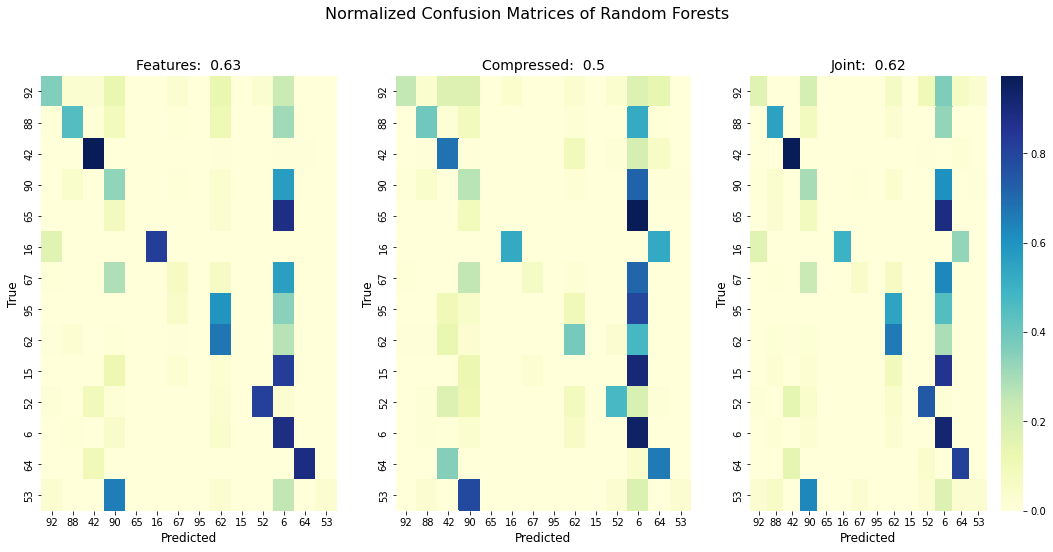

In [20]:
#Define labels and text quantities for each model
labels=y.unique()
df_list = [feat_conf, comp_conf, joint_conf]
score_list = [feat_score, comp_score, joint_score]
title_list = ['Features', 'Compressed', 'Joint']

#Generate subplots
fig, axs = pl.subplots(1, 3, figsize=(18,8))
axs = axs.flatten()

for i in range(0,3):
  bar = False if i != 2 else True
  matrix = df_list[i].div(df_list[i].sum(axis=1), axis=0)
  sns.heatmap(matrix, cmap="YlGnBu", cbar=bar, annot=False,
              ax=axs[i])
  axs[i].set_title(f'{title_list[i]}:  {np.around(score_list[i],2)}', fontsize=14)
  axs[i].set_xlabel('Predicted', fontsize=12)
  axs[i].set_ylabel('True', fontsize=12)

fig.suptitle('Normalized Confusion Matrices of Random Forests',
             y=1, fontsize=16);

**Figure 5:** Normalized Confusion Matrix of each of our Random Forests. The features used in generated each Random Forest are indicated in the titles of each plot as well as the accuracy on test data. 'Features' refers to the features engineered in HW7, 'Compressed' refers to only the output of our autoencoder, and 'Joint' refers to both sets of features together. The ith,jth element indicates the proportion of objects of class i which were predicted to be of class j. 

The Feature based and Joint models do well at predicting class 42, 16, 62, 52, 6, and 64. The model trained only on the compressed output from our autoencoder correctly classified significantly fewer classes correctly (hence the lower accuracy score). A large numper of objects in the test set were predicted disproportionately to be of class 6, meaning that all models over-predict this particular class. Although this is very interesting, to understand why would be a bit beyond the scope here.

Further, the similarity in accuracy between the feature and joint models suggest that comparatively little information is contained within the compressed features. This is backed up by the lower accuracy score of the compressed model. However, the compressed model did perform above chance so there is at least something there which is useful in making predictions